<a href="https://colab.research.google.com/github/colinchu1/CAP4630/blob/master/HW4/HW_4(problem3_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

##Download Data
Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 20:22:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 2607:f8b0:400e:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   125MB/s    in 0.5s    

2020-04-19 20:22:23 (125 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##Build network with MobileNetV2 convolution base and custom densely connected layers

###Load the convolutional base

In [5]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


###Freeze the convolutional base

In [0]:
conv_base.trainable = False

###Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8192256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 10,450,754
Trainable params: 8,192,770
Non-trainable params: 2,257,984
_________________________________________________________________


#Train the model end to end with frozen convolutional base

This note book will be using categorical classifier instead of binary



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# compile model

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 26s 257ms/step - loss: 0.4959 - acc: 0.7965 - val_loss: 0.1569 - val_acc: 0.9360
Epoch 2/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3695 - acc: 0.8515 - val_loss: 0.3240 - val_acc: 0.9060
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3283 - acc: 0.8635 - val_loss: 0.3586 - val_acc: 0.8510
Epoch 4/30
100/100 [==============================] - 17s 166ms/step - loss: 0.2923 - acc: 0.8760 - val_loss: 0.3472 - val_acc: 0.9120
Epoch 5/30
100/100 [==============================] - 17s 167ms/step - loss: 0.2856 - acc: 0.8845 - val_loss: 0.2851 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 17s 168ms/step - loss: 0.2816 - acc: 0.8790 - val_loss: 0.0088 - val_acc: 0.9090
Epoch 7/30
100/100 [==============================] - 17s 170ms/step - loss: 0.2685 - acc: 0.8870 - val_loss: 0.0137 - val_acc: 0.9290
Epoch 8/30
100/100 [==============================] - 1

#Display curves of loss and accuracy during training

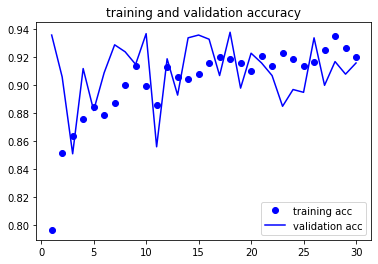

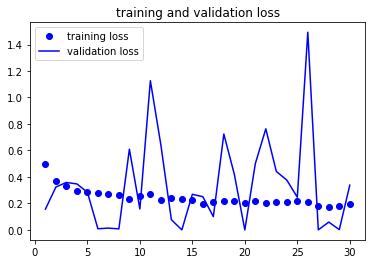

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#Fine-tuning
### I chose to unfreeze block_5_expand in mobilenetV2

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block_5_expand':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [17]:
# compile model

model.compile(
    loss='categorical_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 28s 280ms/step - loss: 0.1864 - acc: 0.9310 - val_loss: 0.2905 - val_acc: 0.8940
Epoch 2/30
100/100 [==============================] - 20s 198ms/step - loss: 0.1927 - acc: 0.9320 - val_loss: 0.1113 - val_acc: 0.9470
Epoch 3/30
100/100 [==============================] - 20s 201ms/step - loss: 0.1512 - acc: 0.9415 - val_loss: 0.3447 - val_acc: 0.9210
Epoch 4/30
100/100 [==============================] - 20s 199ms/step - loss: 0.1559 - acc: 0.9405 - val_loss: 0.0168 - val_acc: 0.9570
Epoch 5/30
100/100 [==============================] - 19s 194ms/step - loss: 0.1562 - acc: 0.9390 - val_loss: 0.5451 - val_acc: 0.9580
Epoch 6/30
100/100 [==============================] - 20s 196ms/step - loss: 0.1468 - acc: 0.9460 - val_loss: 0.0283 - val_acc: 0.9540
Epoch 7/30
100/100 [==============================] - 20s 198ms/step - loss: 0.1362 - acc: 0.9450 - val_loss: 0.2081 - val_acc: 0.9600
Epoch 8/30
100/100 [==============================] - 2

#Display learning curves during fine-tuning

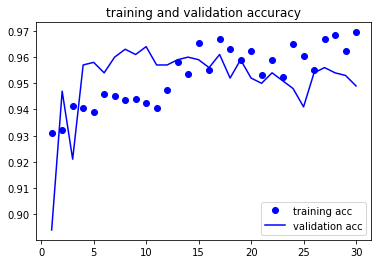

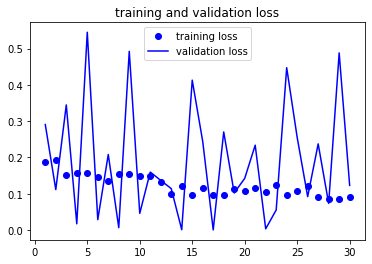

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

the validation loss fluctuating, probably caused by high learning rate

#Print out validation loss and accuracy 

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [20]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.12278135120868683
Validation accuracy: 0.9490000009536743


#Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)